## Necessary Module Importation

### BUSINESS UNDERSTANDING

**PROJECT TITLE**: Forecasting Store Sales for Improved Decision-Making Using Machine Learning for Time Series Data

#### PROJECT OVERVIEW

Accurate sales forecasting is critical for businesses across industries, offering tangible benefits like optimized inventory management, efficient resource allocation (e.g., human resources, production capacity, marketing budgets), optimized production schedules, and effective marketing strategies.

The project aims to build a model that accurately predicts unit sales for various items sold at different Favorita stores. Favorita is a major grocery retailer based in Ecuador.


In [2]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
import category_encoders as ce


from datetime import datetime, timedelta
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_squared_log_error, r2_score
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.feature_selection import SelectKBest, f_regression
from xgboost import XGBRegressor
from sklearn.preprocessing import PolynomialFeatures
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm


import gdown
import logging
import pyodbc
from scipy.stats import shapiro, ttest_ind
import warnings
warnings.filterwarnings('ignore')


C:\Users\Hp\AppData\Local\Temp\ipykernel_3544\3747543584.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


We begin by importing the necessary libraries

**Data Wrangling Imports:**
- **NumPy (`np`):** Fundamental package for scientific computing with Python.
- **Pandas (`pd`):** Data manipulation and analysis library.
- **Matplotlib (`plt`):** Plotting library for creating visualizations.
- **Seaborn (`sns`):** Data visualization library based on Matplotlib.
- **OS (`os`):** Provides a way to interact with the operating system, offering functionality like file and directory manipulation.
- **dotenv (`dotenv_values`):** Loads environment variables from a `.env` file.
- **Sklearn Preprocessing:**
  - `OneHotEncoder`: Encodes categorical integer features.
  - `StandardScaler`: Standardizes features by removing the mean and scaling to unit variance.
  - `LabelEncoder`: Converts categorical labels into numerical representations.
- **Sklearn Impute (`SimpleImputer`):** Imputation for handling missing values.

**Time Series Imports:**
- **Datetime (`datetime`, `timedelta`):** Handles dates and times in Python.
- **Statsmodels Time Series Analysis:**
  - `CalendarFourier`: Adds Fourier terms for calendar effects.
  - `DeterministicProcess`: Represents a deterministic process.
- **Statsmodels Graphics (`plot_pacf`, `plot_acf`):** Plots partial autocorrelation and autocorrelation functions.

**Machine Learning Models Import:**
- **Sklearn Linear Models (`LinearRegression`):** Implements linear regression models.
- **Sklearn Tree (`DecisionTreeRegressor`):** Implements decision tree regression models.
- **Sklearn Ensemble (`RandomForestRegressor`):** Implements random forest regression models.
- **Sklearn Metrics:**
  - `mean_absolute_error`: Computes the mean absolute error.
  - `mean_squared_error`: Computes the mean squared error.
  - `mean_squared_log_error`: Computes the mean squared logarithmic error.
  - `r2_score`: Computes the R-squared score.
- **Sklearn Model Selection:**
  - `train_test_split`: Splits datasets into training and testing sets.
  - `GridSearchCV`: Performs grid search with cross-validation.
  - `cross_val_score`: Evaluates cross-validated scores.
- **Sklearn Feature Selection:**
  - `SelectKBest`: Selects top features based on statistical tests.
  - `f_regression`: Computes F-value for feature ranking.
- **XGBoost (`XGBRegressor`):** Implements XGBoost regression models.
- **Sklearn Preprocessing (`PolynomialFeatures`):** Generates polynomial features.
- **Statsmodels (`variance_inflation_factor`):** Detects multicollinearity in linear regression.
- **Statsmodels API (`sm`):** Provides statistical models and tests.

**Additional Imports:**
- **gdown (`gdown`):** Downloads files from Google Drive.
- **Logging (`logging`):** Library for tracking events and debugging.
- **pyodbc (`pyodbc`):** Python module for connecting to ODBC databases.
- **SciPy Statistical Tests:**
  - `shapiro`: Performs the Shapiro-Wilk test for normality.
  - `ttest_ind`: Performs an independent two-sample t-test.
- **Warnings (`warnings`):** Control warning messages; set to ignore warnings.

### Dataset

In [3]:
holidays_data = pd.read_csv('Csv_files\holiday_data.csv')
holidays_data.head()

,Unnamed: 0,date,type,locale,locale_name,description,transferred
0,0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False


In [4]:
oil_data = pd.read_csv('Csv_files\oil_data.csv')
oil_data.head()

,Unnamed: 0,date,dcoilwtico
0,0,2013-01-01,NaN
1,1,2013-01-02,93.139999
2,2,2013-01-03,92.970001
3,3,2013-01-04,93.120003
4,4,2013-01-07,93.199997


In [5]:
stores_data = pd.read_csv('Csv_files\stores_data.csv')
stores_data.head()

,Unnamed: 0,store_nbr,city,state,type,cluster
0,0,1,Quito,Pichincha,D,13
1,1,2,Quito,Pichincha,D,13
2,2,3,Quito,Pichincha,D,8
3,3,4,Quito,Pichincha,D,9
4,4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4


In [6]:
test_data = pd.read_csv('Csv_files\\test.csv')
test_data.head()

,id,date,store_nbr,family,onpromotion
0,3000888,2017-08-16,1,AUTOMOTIVE,0
1,3000889,2017-08-16,1,BABY CARE,0
2,3000890,2017-08-16,1,BEAUTY,2
3,3000891,2017-08-16,1,BEVERAGES,20
4,3000892,2017-08-16,1,BOOKS,0


In [7]:
train_data = pd.read_csv('Csv_files\\train_data.csv')
train_data.head()

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,1,2013-01-01,1,BABY CARE,0.0,0
2,2,2013-01-01,1,BEAUTY,0.0,0
3,3,2013-01-01,1,BEVERAGES,0.0,0
4,4,2013-01-01,1,BOOKS,0.0,0


In [8]:
transactions_data = pd.read_csv('Csv_files\\transactions.csv')
transactions_data.head()

,date,store_nbr,transactions
0,2013-01-01,25,770
1,2013-01-02,1,2111
2,2013-01-02,2,2358
3,2013-01-02,3,3487
4,2013-01-02,4,1922


### Data Wrangling

In [9]:
holidays_data

,Unnamed: 0,date,type,locale,locale_name,description,transferred
0,0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False
...,...,...,...,...,...,...,...
345,345,2017-12-22,Additional,National,Ecuador,Navidad-3,False
346,346,2017-12-23,Additional,National,Ecuador,Navidad-2,False
347,347,2017-12-24,Additional,National,Ecuador,Navidad-1,False
348,348,2017-12-25,Holiday,National,Ecuador,Navidad,False


In [10]:
holidays_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 350 entries, 0 to 349
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Unnamed: 0   350 non-null    int64 
 1   date         350 non-null    object
 2   type         350 non-null    object
 3   locale       350 non-null    object
 4   locale_name  350 non-null    object
 5   description  350 non-null    object
 6   transferred  350 non-null    bool  
dtypes: bool(1), int64(1), object(5)
memory usage: 16.9+ KB


Date column is in 'Object' format

In [11]:
holidays_data.describe()

,Unnamed: 0
count,350.000000
mean,174.500000
std,101.180532
min,0.000000
25%,87.250000
50%,174.500000
75%,261.750000
max,349.000000


In [12]:
holidays_data.isnull().sum()

Unnamed: 0     0
date           0
type           0
locale         0
locale_name    0
description    0
transferred    0
dtype: int64

In [13]:
holidays_data.duplicated().sum()

0

In [14]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28512 entries, 0 to 28511
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           28512 non-null  int64 
 1   date         28512 non-null  object
 2   store_nbr    28512 non-null  int64 
 3   family       28512 non-null  object
 4   onpromotion  28512 non-null  int64 
dtypes: int64(3), object(2)
memory usage: 1.1+ MB


Date column is in 'Object' format

In [15]:
test_data.describe()

,id,store_nbr,onpromotion
count,2.851200e+04,28512.000000,28512.000000
mean,3.015144e+06,27.500000,6.965383
std,8.230850e+03,15.586057,20.683952
min,3.000888e+06,1.000000,0.000000
25%,3.008016e+06,14.000000,0.000000
50%,3.015144e+06,27.500000,0.000000
75%,3.022271e+06,41.000000,6.000000
max,3.029399e+06,54.000000,646.000000


In [16]:
test_data.isnull().sum()

id             0
date           0
store_nbr      0
family         0
onpromotion    0
dtype: int64

In [17]:
test_data.duplicated().sum()

0

In [18]:
transactions_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83488 entries, 0 to 83487
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   date          83488 non-null  object
 1   store_nbr     83488 non-null  int64 
 2   transactions  83488 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 1.9+ MB


Date column is in 'Object' format

In [19]:
transactions_data.describe()

,store_nbr,transactions
count,83488.000000,83488.000000
mean,26.939237,1694.602158
std,15.608204,963.286644
min,1.000000,5.000000
25%,13.000000,1046.000000
50%,27.000000,1393.000000
75%,40.000000,2079.000000
max,54.000000,8359.000000


In [20]:
transactions_data.isnull().sum()

date            0
store_nbr       0
transactions    0
dtype: int64

In [21]:
transactions_data.duplicated().sum()

0

In [22]:
oil_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1218 entries, 0 to 1217
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  1218 non-null   int64  
 1   date        1218 non-null   object 
 2   dcoilwtico  1175 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 28.7+ KB


Date column is in 'Object' format

In [23]:
oil_data.isnull().sum()

Unnamed: 0     0
date           0
dcoilwtico    43
dtype: int64

In [24]:
oil_data.duplicated().sum()

0

In [25]:
stores_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54 entries, 0 to 53
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  54 non-null     int64 
 1   store_nbr   54 non-null     int64 
 2   city        54 non-null     object
 3   state       54 non-null     object
 4   type        54 non-null     object
 5   cluster     54 non-null     int64 
dtypes: int64(3), object(3)
memory usage: 2.7+ KB


In [26]:
stores_data.describe()

,Unnamed: 0,store_nbr,cluster
count,54.000000,54.000000,54.000000
mean,26.500000,27.500000,8.481481
std,15.732133,15.732133,4.693395
min,0.000000,1.000000,1.000000
25%,13.250000,14.250000,4.000000
50%,26.500000,27.500000,8.500000
75%,39.750000,40.750000,13.000000
max,53.000000,54.000000,17.000000


In [27]:
stores_data.isnull().sum()

Unnamed: 0    0
store_nbr     0
city          0
state         0
type          0
cluster       0
dtype: int64

In [28]:
stores_data.duplicated().sum()

0

In [29]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000888 entries, 0 to 3000887
Data columns (total 6 columns):
 #   Column       Dtype  
---  ------       -----  
 0   id           int64  
 1   date         object 
 2   store_nbr    int64  
 3   family       object 
 4   sales        float64
 5   onpromotion  int64  
dtypes: float64(1), int64(3), object(2)
memory usage: 137.4+ MB


Date column is in 'Object' format

In [30]:
train_data.describe()

,id,store_nbr,sales,onpromotion
count,3.000888e+06,3.000888e+06,3.000888e+06,3.000888e+06
mean,1.500444e+06,2.750000e+01,3.577757e+02,2.602770e+00
std,8.662819e+05,1.558579e+01,1.101998e+03,1.221888e+01
min,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00
25%,7.502218e+05,1.400000e+01,0.000000e+00,0.000000e+00
50%,1.500444e+06,2.750000e+01,1.100000e+01,0.000000e+00
75%,2.250665e+06,4.100000e+01,1.958473e+02,0.000000e+00
max,3.000887e+06,5.400000e+01,1.247170e+05,7.410000e+02


In [31]:
train_data.isnull().sum()

id             0
date           0
store_nbr      0
family         0
sales          0
onpromotion    0
dtype: int64

In [32]:
train_data.duplicated().sum()

0

### Data Visualization

#### Univariate Analysis

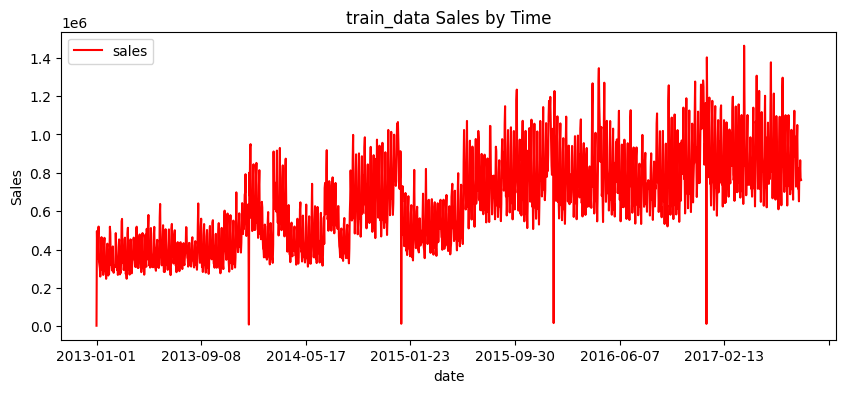

In [33]:
train_sales_by_time = train_data.groupby('date').sales.sum().reset_index()    
train_sales_by_time = train_sales_by_time.set_index('date')

train_sales_by_time.plot(figsize = (10,4), color= ('red'))
plt.title('train_data Sales by Time')
plt.ylabel('Sales')
plt.show()

The train_data plot demonstrates a consistent upward trend in sales as we move towards the right.

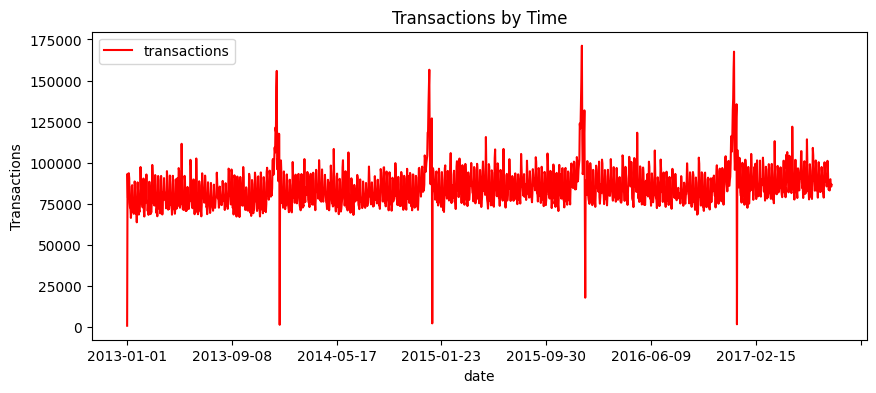

In [34]:
transaction_sum_by_time = transactions_data.groupby('date').transactions.sum().reset_index()
transaction_sum_by_time = transaction_sum_by_time.set_index('date')

transaction_sum_by_time.plot(figsize = (10,4), color= ('red'))
plt.title('Transactions by Time')
plt.ylabel('Transactions')
plt.show()

A clear observation reveals a consistent rise in yearly transactions towards the right, with 2016 standing out as the year with the highest sales records. However, the month-to-month records indicate relatively stable transaction levels over the recorded years. The only exceptions are the year-end periods, where sharp increases in transactions occur, indicating a seasonal pattern.

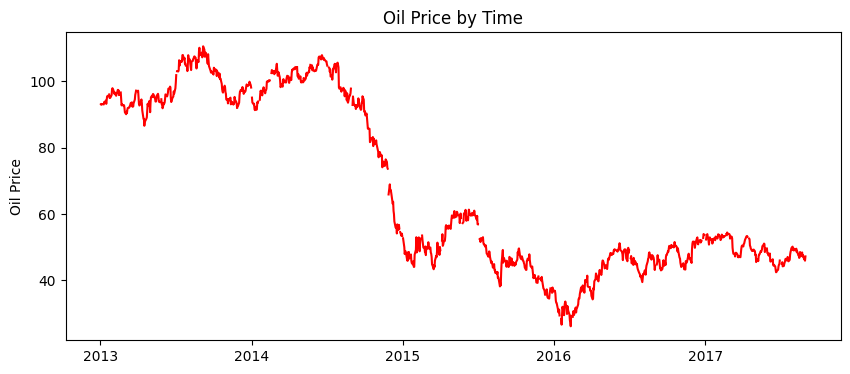

In [35]:
oil_data['date'] = pd.to_datetime(oil_data['date'])
dcoilwtico_by_time = oil_data.groupby('date')['dcoilwtico'].mean().reset_index()
dcoilwtico_by_time = dcoilwtico_by_time.set_index('date')

plt.figure(figsize=(10, 4))
plt.plot(dcoilwtico_by_time.index, dcoilwtico_by_time['dcoilwtico'], color='red')
plt.title('Oil Price by Time')
plt.ylabel('Oil Price')
plt.show()

The trend indicates a decrease in oil prices from 2015. Additionally, a noticeable disruption in the trend is attributed to the presence of missing or NaN values.

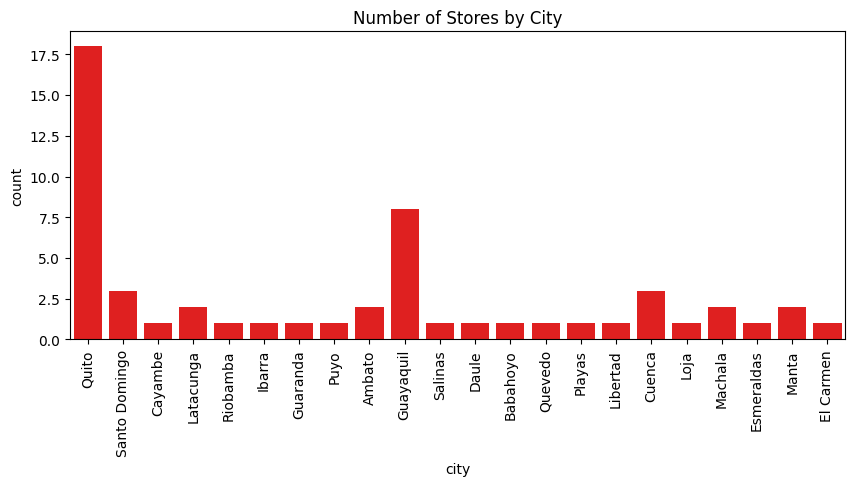

In [36]:
stores_data.set_index('store_nbr', inplace=True)
plt.figure(figsize=(10, 4))
sns.countplot(data=stores_data, x='city', color= 'red')
plt.xticks(rotation=90)
plt.title('Number of Stores by City')
plt.show()

The visual representation indicates that Quito and Guayaquil boast the highest store counts, while other cities maintain an average of one store per city.

#### Holidays investigation

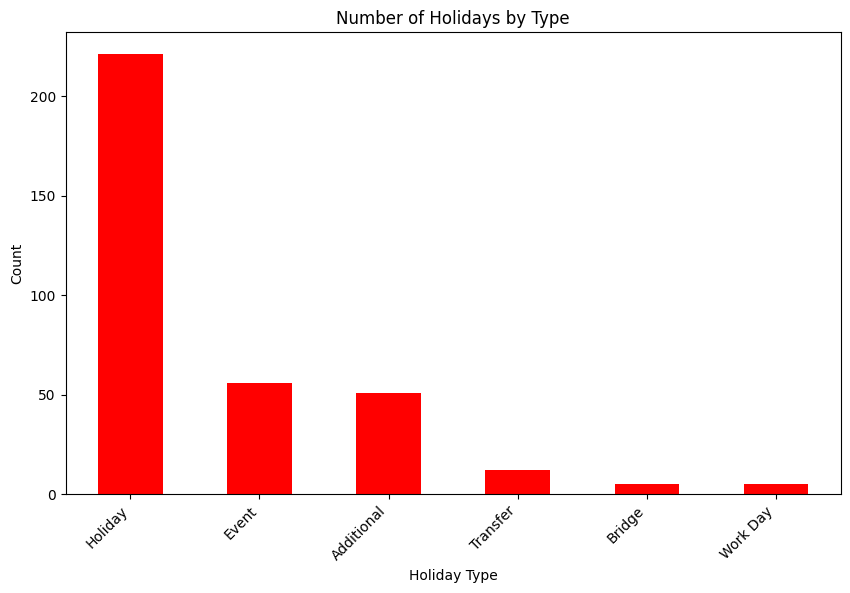

In [37]:
holiday_counts = holidays_data['type'].value_counts()

plt.figure(figsize=(10, 6))
holiday_counts.plot(kind='bar', color='red')
plt.title('Number of Holidays by Type')
plt.xlabel('Holiday Type')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.show()


In [38]:
transferred_holidays = holidays_data[holidays_data['transferred'] == True][['date', 'transferred', 'type']]
observed_transferred_holidays = holidays_data[holidays_data.type == 'Transfer']
work_days_holidays = holidays_data[holidays_data.type == 'Work Day']    
additional_holidays = holidays_data[holidays_data.type == 'Additional']
bridge_holidays = holidays_data[holidays_data.type == 'Bridge']
national_holidays = holidays_data[holidays_data.type == 'National']
regional_holidays = holidays_data[holidays_data.type == 'Regional']
event_holidays = holidays_data[holidays_data.type == 'Event']

In [39]:

transferred_holidays

,date,transferred,type
19,2012-10-09,True,Holiday
72,2013-10-09,True,Holiday
135,2014-10-09,True,Holiday
255,2016-05-24,True,Holiday
266,2016-07-25,True,Holiday
268,2016-08-10,True,Holiday
297,2017-01-01,True,Holiday
303,2017-04-12,True,Holiday
312,2017-05-24,True,Holiday
324,2017-08-10,True,Holiday


In [40]:
observed_transferred_holidays

,Unnamed: 0,date,type,locale,locale_name,description,transferred
20,20,2012-10-12,Transfer,National,Ecuador,Traslado Independencia de Guayaquil,False
73,73,2013-10-11,Transfer,National,Ecuador,Traslado Independencia de Guayaquil,False
136,136,2014-10-10,Transfer,National,Ecuador,Traslado Independencia de Guayaquil,False
256,256,2016-05-27,Transfer,National,Ecuador,Traslado Batalla de Pichincha,False
265,265,2016-07-24,Transfer,Local,Guayaquil,Traslado Fundacion de Guayaquil,False
269,269,2016-08-12,Transfer,National,Ecuador,Traslado Primer Grito de Independencia,False
298,298,2017-01-02,Transfer,National,Ecuador,Traslado Primer dia del ano,False
304,304,2017-04-13,Transfer,Local,Cuenca,Fundacion de Cuenca,False
313,313,2017-05-26,Transfer,National,Ecuador,Traslado Batalla de Pichincha,False
325,325,2017-08-11,Transfer,National,Ecuador,Traslado Primer Grito de Independencia,False


The above demonstrates the specific days on which the transferred holidays were observed.

In [41]:
work_days_holidays

,Unnamed: 0,date,type,locale,locale_name,description,transferred
42,42,2013-01-05,Work Day,National,Ecuador,Recupero puente Navidad,False
43,43,2013-01-12,Work Day,National,Ecuador,Recupero puente primer dia del ano,False
149,149,2014-12-20,Work Day,National,Ecuador,Recupero Puente Navidad,False
161,161,2015-01-10,Work Day,National,Ecuador,Recupero Puente Primer dia del ano,False
283,283,2016-11-12,Work Day,National,Ecuador,Recupero Puente Dia de Difuntos,False


In [42]:
additional_holidays

,Unnamed: 0,date,type,locale,locale_name,description,transferred
28,28,2012-12-05,Additional,Local,Quito,Fundacion de Quito-1,False
31,31,2012-12-21,Additional,National,Ecuador,Navidad-4,False
33,33,2012-12-22,Additional,National,Ecuador,Navidad-3,False
34,34,2012-12-23,Additional,National,Ecuador,Navidad-2,False
36,36,2012-12-24,Additional,National,Ecuador,Navidad-1,False
38,38,2012-12-26,Additional,National,Ecuador,Navidad+1,False
40,40,2012-12-31,Additional,National,Ecuador,Primer dia del ano-1,False
53,53,2013-05-11,Additional,National,Ecuador,Dia de la Madre-1,False
64,64,2013-07-24,Additional,Local,Guayaquil,Fundacion de Guayaquil-1,False
81,81,2013-12-05,Additional,Local,Quito,Fundacion de Quito-1,False


In [43]:
bridge_holidays

,Unnamed: 0,date,type,locale,locale_name,description,transferred
35,35,2012-12-24,Bridge,National,Ecuador,Puente Navidad,False
39,39,2012-12-31,Bridge,National,Ecuador,Puente Primer dia del ano,False
156,156,2014-12-26,Bridge,National,Ecuador,Puente Navidad,False
160,160,2015-01-02,Bridge,National,Ecuador,Puente Primer dia del ano,False
277,277,2016-11-04,Bridge,National,Ecuador,Puente Dia de Difuntos,False


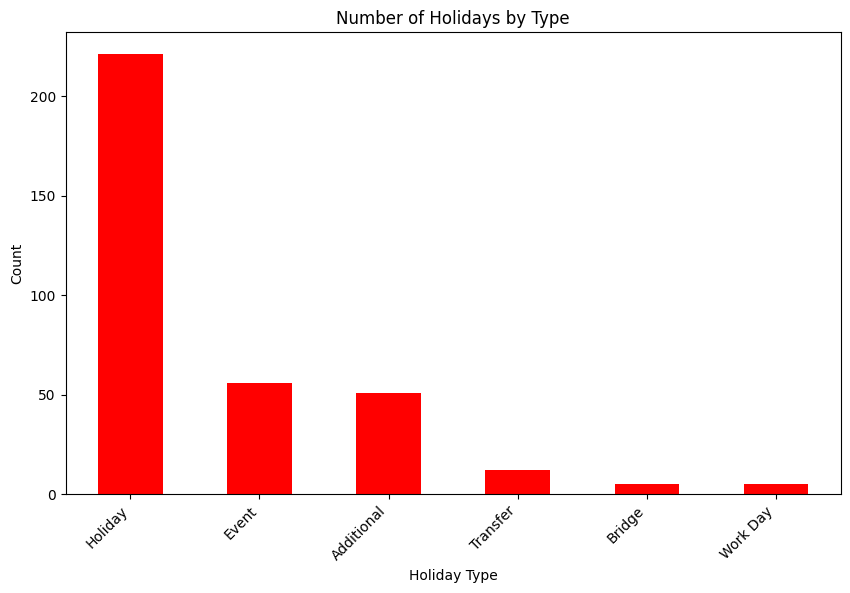

In [44]:
holiday_counts = holidays_data['type'].value_counts()

plt.figure(figsize=(10, 6))
holiday_counts.plot(kind='bar', color='red')
plt.title('Number of Holidays by Type')
plt.xlabel('Holiday Type')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.show()

#### Bivariate Analysis

Converting the date columns to date format

In [45]:
train_data['date'] = pd.to_datetime(train_data['date'])
oil_data['date'] = pd.to_datetime(oil_data['date'])
transactions_data['date'] = pd.to_datetime(transactions_data['date'])
holidays_data['date'] = pd.to_datetime(holidays_data['date'])
test_data['date'] = pd.to_datetime(test_data['date'])


Establishing the relationship between data sets

In [46]:
sales_data = train_data.groupby('date').sales.sum().reset_index()

In [47]:
oil_sales_data = pd.merge(sales_data, oil_data, on='date')
oil_sales_data = oil_sales_data.set_index('date')
oil_sales_data

,sales,Unnamed: 0,dcoilwtico
date,,,
2013-01-01,2511.618999,0,NaN
2013-01-02,496092.417944,1,93.139999
2013-01-03,361461.231124,2,92.970001
2013-01-04,354459.677093,3,93.120003
2013-01-07,336122.801066,4,93.199997
...,...,...,...
2017-08-09,734139.674010,1201,49.590000
2017-08-10,651386.911970,1202,48.540001
2017-08-11,826373.722022,1203,48.810001


### Data inputation

The missing values in the 'oil_sales' dataset will be filled using the seasonal component obtained from the decomposition because of the observation that the missing values share a similar seasonal pattern with the observed data as observed from the plots above.This seasonal imputation helps maintain the temporal structure of the data and allows for a more accurate representation of the time series.
Formula: Y(t) = Level * Trend * Seasonal * Residual

In [48]:
from statsmodels.tsa.seasonal import seasonal_decompose

def seasonal_imputation(data):
    decomposition = seasonal_decompose(data['sales'], period=12)  
    
    
    data['sales_imputed'] = data['sales'].fillna(decomposition.seasonal)
    data['dcoilwtico_inputed'] = data['dcoilwtico'].fillna(method='bfill')
    
    return data

oil_sales_data = seasonal_imputation(oil_sales_data)
print(oil_sales_data)


                    sales  Unnamed: 0  dcoilwtico  sales_imputed  \
date                                                               
2013-01-01    2511.618999           0         NaN    2511.618999   
2013-01-02  496092.417944           1   93.139999  496092.417944   
2013-01-03  361461.231124           2   92.970001  361461.231124   
2013-01-04  354459.677093           3   93.120003  354459.677093   
2013-01-07  336122.801066           4   93.199997  336122.801066   
...                   ...         ...         ...            ...   
2017-08-09  734139.674010        1201   49.590000  734139.674010   
2017-08-10  651386.911970        1202   48.540001  651386.911970   
2017-08-11  826373.722022        1203   48.810001  826373.722022   
2017-08-14  760922.406081        1204   47.590000  760922.406081   
2017-08-15  762661.935939        1205   47.570000  762661.935939   

            dcoilwtico_inputed  
date                            
2013-01-01           93.139999  
2013-01-02      

In [49]:
oil_sales_data.drop(columns=['sales', 'dcoilwtico'], inplace=True)
oil_sales_data.rename(columns={'sales_imputed': 'sales', 'dcoilwtico_inputed': 'dcoilwtico'}, inplace=True)
oil_sales_data

,Unnamed: 0,sales,dcoilwtico
date,,,
2013-01-01,0,2511.618999,93.139999
2013-01-02,1,496092.417944,93.139999
2013-01-03,2,361461.231124,92.970001
2013-01-04,3,354459.677093,93.120003
2013-01-07,4,336122.801066,93.199997
...,...,...,...
2017-08-09,1201,734139.674010,49.590000
2017-08-10,1202,651386.911970,48.540001
2017-08-11,1203,826373.722022,48.810001


Visual Test for seasonality and Trend

Upon investigating the dataset, it is evident that visualizing the sales series across all 1800 series (store-family combinations) is nearly impractical.

To discern common trends and patterns among various store-family combinations, we opt for an aggregated analysis employing average daily sales. This approach proves valuable in comprehending overall market trends, seasonalities, and shared characteristics.

Once insights are gleaned from the aggregated data, we proceed with feature engineering to encapsulate these observed patterns.

However, the trade-off in this strategy lies in potentially sacrificing granularity and the ability to capture nuances specific to individual series. It represents a delicate balance between simplicity and detail.


In [52]:
average_daily_sales = train_data.groupby(["date", "store_nbr", "family"])["sales"].mean()
average_daily_sales = average_daily_sales.reset_index()
average_daily_sales 


,date,store_nbr,family,sales
0,2013-01-01,1,AUTOMOTIVE,0.000
1,2013-01-01,1,BABY CARE,0.000
2,2013-01-01,1,BEAUTY,0.000
3,2013-01-01,1,BEVERAGES,0.000
4,2013-01-01,1,BOOKS,0.000
...,...,...,...,...
3000883,2017-08-15,54,POULTRY,59.619
3000884,2017-08-15,54,PREPARED FOODS,94.000
3000885,2017-08-15,54,PRODUCE,915.371
3000886,2017-08-15,54,SCHOOL AND OFFICE SUPPLIES,0.000


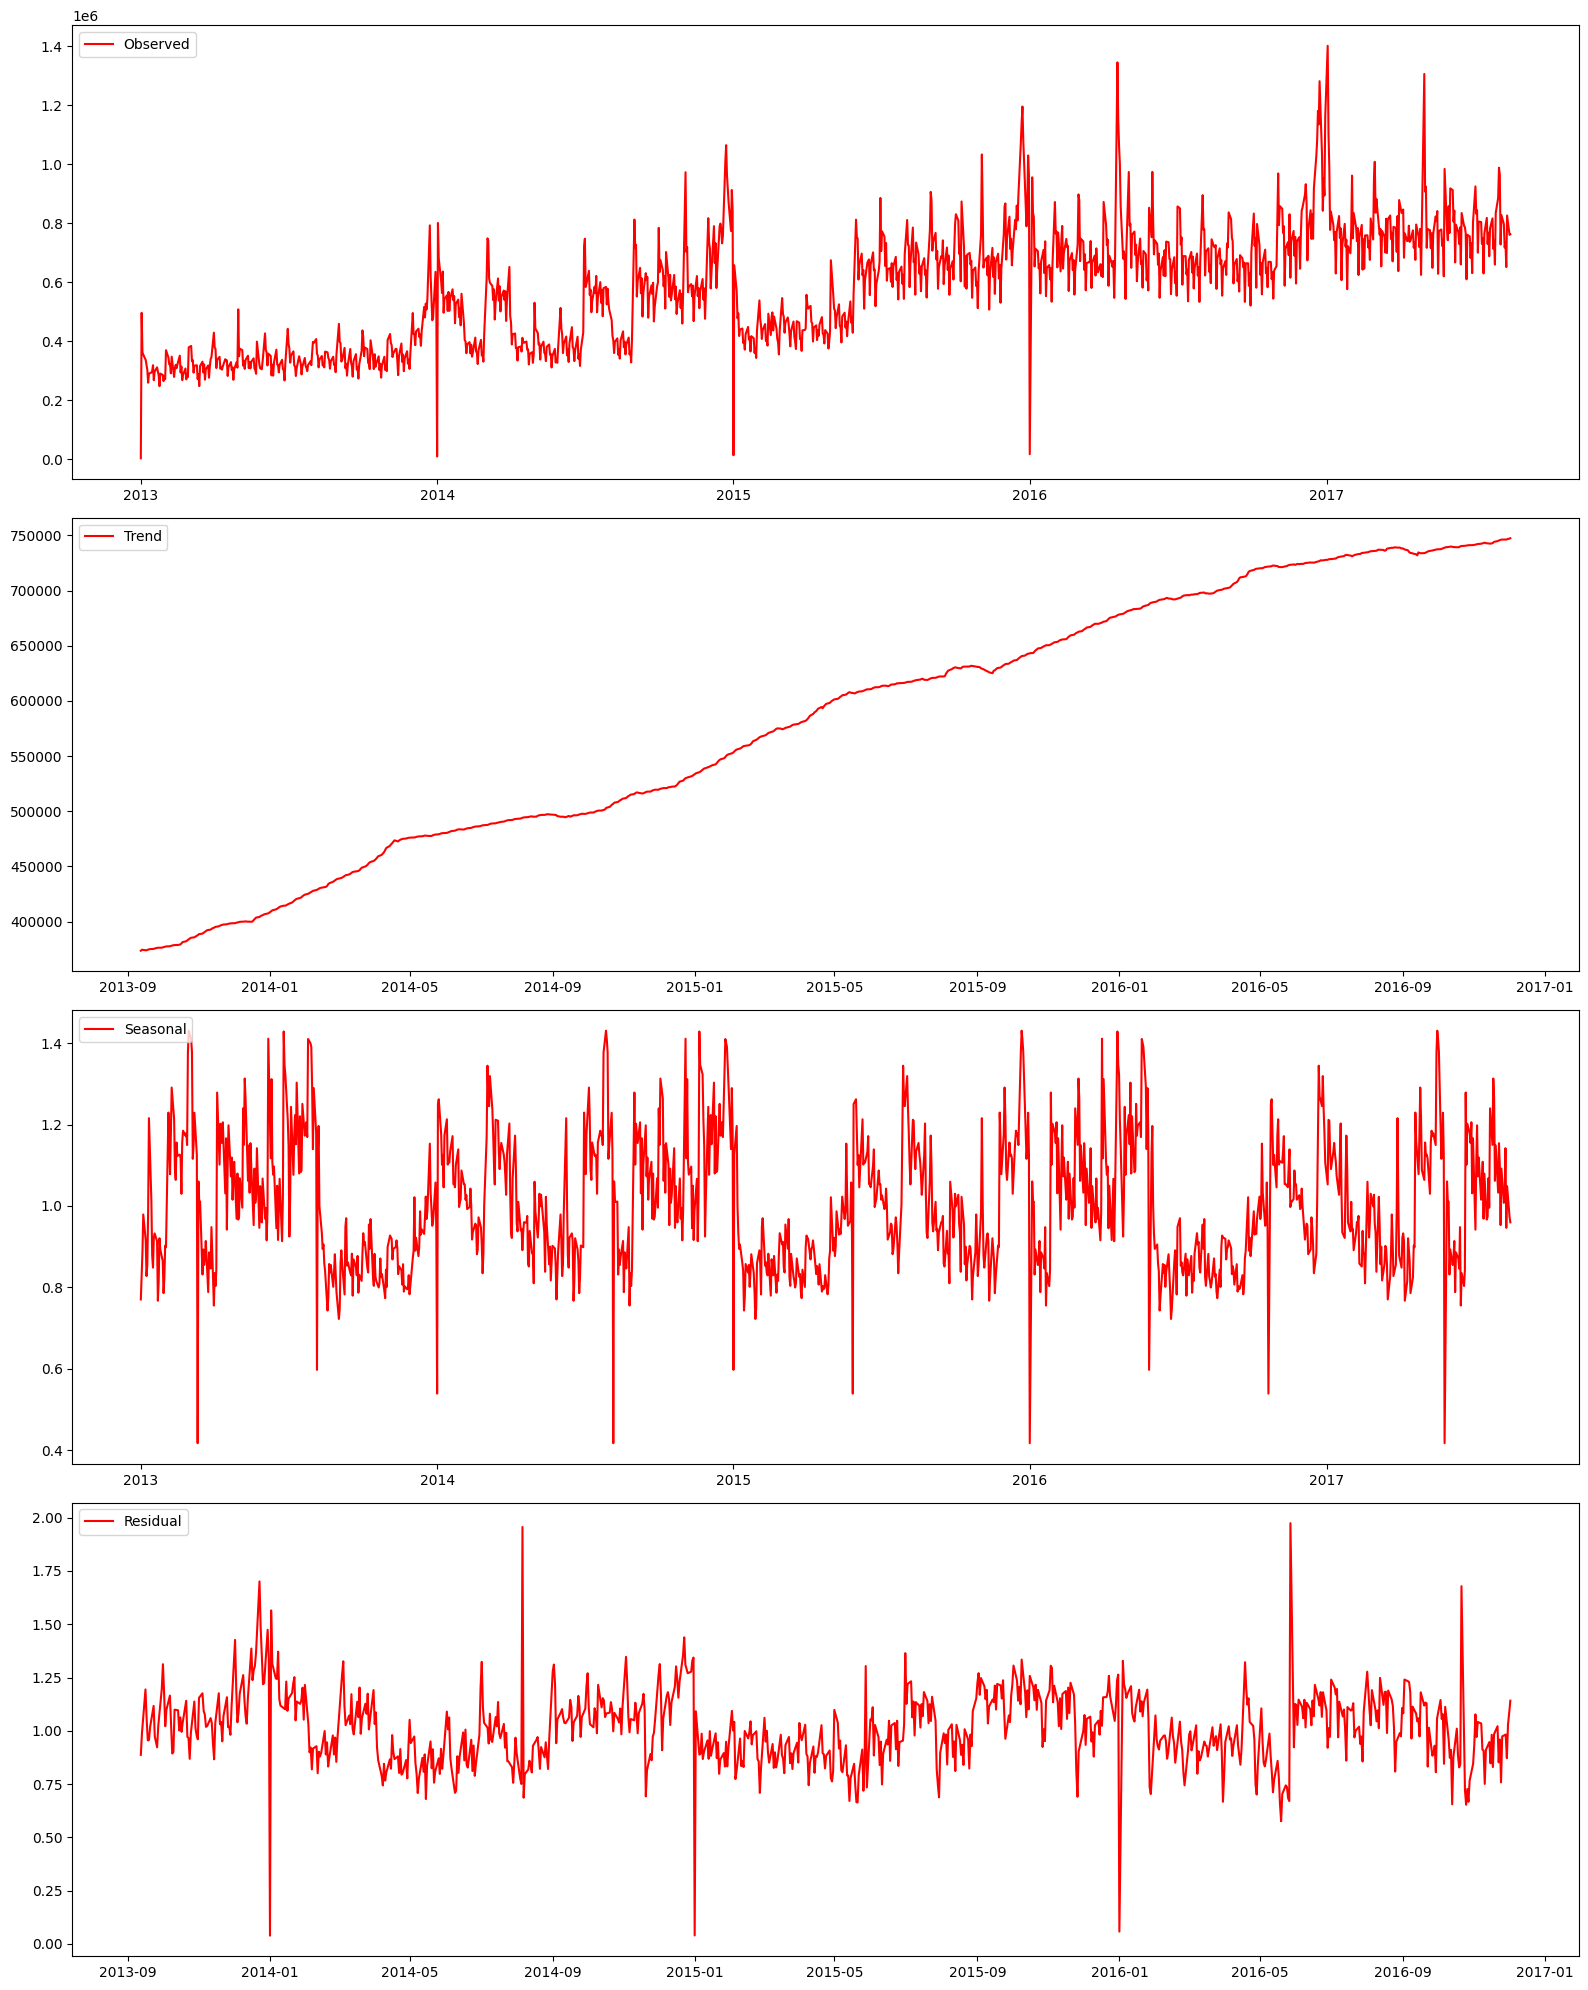

In [53]:
result = seasonal_decompose(oil_sales_data['sales'], model='multiplicative', period=365)

plt.figure(figsize=(16,20)) 

plt.subplot(4, 1, 1)
plt.plot(result.observed, label='Observed', color='red')
plt.legend(loc='upper left')

plt.subplot(4, 1, 2)
plt.plot(result.trend, label='Trend', color='red')
plt.legend(loc='upper left')

plt.subplot(4, 1, 3)
plt.plot(result.seasonal, label='Seasonal', color='red')
plt.legend(loc='upper left')

plt.subplot(4, 1, 4)
plt.plot(result.resid, label='Residual', color='red')
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()



In [ ]:
oil_sales_data

,Unnamed: 0,sales,dcoilwtico
date,,,
2013-01-01,0.0,2511.618999,93.139999
2013-01-02,1.0,496092.417944,93.139999
2013-01-03,2.0,361461.231124,92.970001
2013-01-04,3.0,354459.677093,93.120003
2013-01-05,NaN,477350.121229,93.199997
...,...,...,...
2017-08-11,1203.0,826373.722022,48.810001
2017-08-12,NaN,792630.535079,47.590000
2017-08-13,NaN,865639.677471,47.590000


In [ ]:
oil_sales_data.drop(columns = ['Unnamed: 0'], inplace=True)
oil_sales_data['oil_price_pct_change'] = oil_sales_data['dcoilwtico'].pct_change() * 100
oil_sales_data['sales_pct_change'] = oil_sales_data['sales'].pct_change() * 100
oil_sales_data

,sales,dcoilwtico,oil_price_pct_change,sales_pct_change
date,,,,
2013-01-01,2511.618999,93.139999,NaN,NaN
2013-01-02,496092.417944,93.139999,0.000000,19651.897805
2013-01-03,361461.231124,92.970001,-0.182519,-27.138328
2013-01-04,354459.677093,93.120003,0.161344,-1.937014
2013-01-05,477350.121229,93.199997,0.085904,34.669795
...,...,...,...,...
2017-08-11,826373.722022,48.810001,0.556243,26.863728
2017-08-12,792630.535079,47.590000,-2.499490,-4.083284
2017-08-13,865639.677471,47.590000,0.000000,9.210993


In [ ]:
oil_sales_data.isna().sum()

sales                   0
dcoilwtico              0
oil_price_pct_change    1
sales_pct_change        1
dtype: int64

In [ ]:
oil_sales_data.dropna(inplace=True)

In [ ]:
oil_sales_data

,sales,dcoilwtico,oil_price_pct_change,sales_pct_change
date,,,,
2013-01-02,496092.417944,93.139999,0.000000,19651.897805
2013-01-03,361461.231124,92.970001,-0.182519,-27.138328
2013-01-04,354459.677093,93.120003,0.161344,-1.937014
2013-01-05,477350.121229,93.199997,0.085904,34.669795
2013-01-06,519695.401088,93.199997,0.000000,8.870906
...,...,...,...,...
2017-08-11,826373.722022,48.810001,0.556243,26.863728
2017-08-12,792630.535079,47.590000,-2.499490,-4.083284
2017-08-13,865639.677471,47.590000,0.000000,9.210993


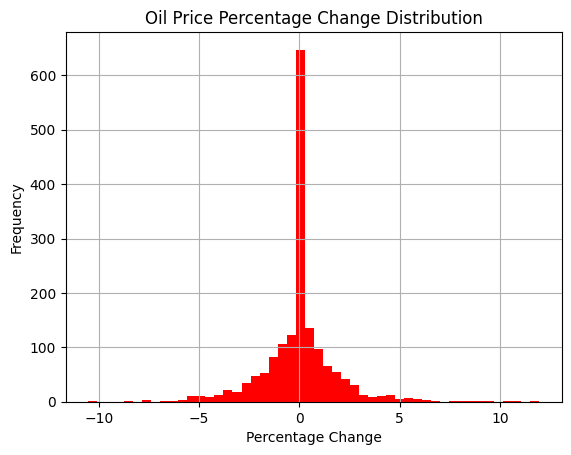

In [ ]:
oil_sales_data['oil_price_pct_change'].hist(bins=50, color='red')
plt.title('Oil Price Percentage Change Distribution')
plt.xlabel('Percentage Change')
plt.ylabel('Frequency')
plt.show()

The histogram analysis of oil price percentage changes reveals distinctive patterns. The distribution exhibits an increase from the left, indicating a higher frequency of negative percentage changes, signifying frequent small declines in oil prices. The steep rise at zero suggests a common occurrence of minimal or no change, emphasizing periods of relative stability. Additionally, the similar decrease to the right highlights a higher frequency of positive percentage changes, denoting frequent small increases in oil prices. This distribution pattern suggests that the oil market tends to experience more periods of stability or small fluctuations, punctuated by occasional larger changes, both positive and negative. Understanding these patterns provides valuable insights into the volatility and stability of oil prices over time.

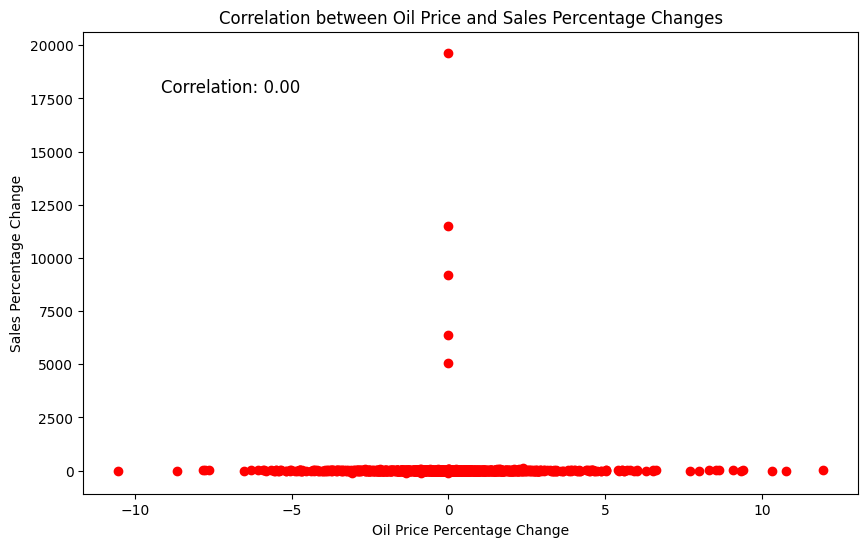

In [ ]:

correlation = oil_sales_data['oil_price_pct_change'].corr(oil_sales_data['sales_pct_change'])

plt.figure(figsize=(10, 6))
plt.scatter(oil_sales_data['oil_price_pct_change'], oil_sales_data['sales_pct_change'], color='red')
plt.title('Correlation between Oil Price and Sales Percentage Changes')
plt.xlabel('Oil Price Percentage Change')
plt.ylabel('Sales Percentage Change')
plt.text(0.1, 0.9, f'Correlation: {correlation:.2f}', transform=plt.gca().transAxes, fontsize=12, verticalalignment='top')
plt.show()


 The correlation analysis between oil prices and sales reveals several key insights. The scatter plot illustrates a consistent relationship between the percentage change in oil prices and the percentage change in sales, forming a straight line pattern with an increase at point zero. This suggests that, on average, sales exhibit a constant percentage change irrespective of fluctuations in oil prices. These findings suggest a relatively stable and linear correlation between oil prices and sales, with a notable sensitivity to small oil price changes.

#### Hypothesis & Questions

1. Is the train dataset complete (has all the required dates)?

In [ ]:
train_data['date'] = pd.to_datetime(train_data['date'])
expected_dates = pd.date_range(start=train_data['date'].min(), end=train_data['date'].max(), freq='D')
missing_dates = expected_dates[~expected_dates.isin(train_data['date'])]

if missing_dates.empty:
    print("The train dataset is complete.")
else:
    print("The train dataset is missing dates:")
    for date in missing_dates:
        print(date)


The train dataset is missing dates:
2013-12-25 00:00:00
2014-12-25 00:00:00
2015-12-25 00:00:00
2016-12-25 00:00:00


The missing dates in the train dataset, specifically on December 25th for the years 2013, 2014, 2015, and 2016, suggest that there might be no data recorded for those particular dates. This could be due to various reasons such as holidays, weekends, or other factors where no sales transactions or relevant information were collected. This because the days fall on different days as shown: 2013-12-25: Wednesday; 2014-12-25: Thursday; 2015-12-25: Friday; 2016-12-25: Sunday.

2. Dates with highest and lowest Sales

Dates with the lowest sales for each year:
         year       date  sales
0        2013 2013-01-01    0.0
648648   2014 2014-01-01    0.0
1297296  2015 2015-01-01    0.0
1945944  2016 2016-01-01    0.0
2596374  2017 2017-01-01    0.0

Dates with the highest sales for each year:
         year       date       sales
562596   2013 2013-11-12   46271.000
1257246  2014 2014-12-08   45361.000
1916586  2015 2015-12-14   40351.460
2163723  2016 2016-05-02  124717.000
2760297  2017 2017-04-02   38422.625


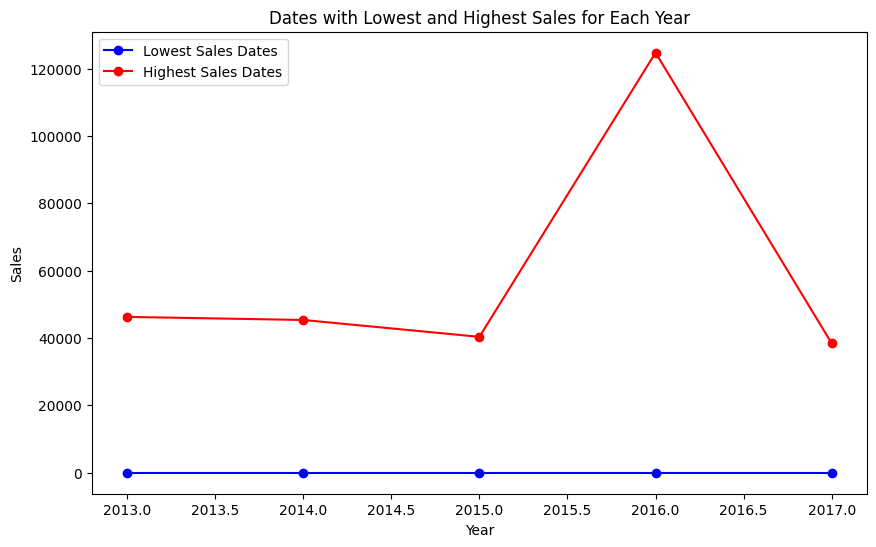

In [ ]:
train_data['date'] = pd.to_datetime(train_data['date'])
train_data['year'] = train_data['date'].dt.year
lowest_sales_dates = train_data.loc[train_data.groupby('year')['sales'].idxmin()][['year', 'date', 'sales']]
highest_sales_dates = train_data.loc[train_data.groupby('year')['sales'].idxmax()][['year', 'date', 'sales']]
print("Dates with the lowest sales for each year:")
print(lowest_sales_dates)
print("\nDates with the highest sales for each year:")
print(highest_sales_dates)


fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(lowest_sales_dates['year'], lowest_sales_dates['sales'], color='blue', label='Lowest Sales Dates', marker='o')
ax.plot(highest_sales_dates['year'], highest_sales_dates['sales'], color='red', label='Highest Sales Dates', marker='o')
ax.set_xlabel('Year')
ax.set_ylabel('Sales')
ax.set_title('Dates with Lowest and Highest Sales for Each Year')
ax.legend()
plt.show()

3. Impact of April 16, 2016 earthquake on sales.

                   sales  dcoilwtico  oil_price_pct_change  sales_pct_change
date                                                                        
2016-03-17  5.804525e+05   40.169998              4.527707        -21.539833
2016-03-18  6.667568e+05   39.470001             -1.742586         14.868449
2016-03-19  8.950385e+05   39.910000              1.114767         34.237624
2016-03-20  9.296056e+05   39.910000              0.000000          3.862076
2016-03-21  6.904698e+05   39.910000              0.000000        -25.724435
...                  ...         ...                   ...               ...
2016-05-12  6.033942e+05   46.639999              0.930535        -17.064170
2016-05-13  6.668339e+05   46.220001             -0.900511         10.513805
2016-05-14  9.328695e+05   47.720001              3.245348         39.895335
2016-05-15  1.070332e+06   47.720001              0.000000         14.735410
2016-05-16  7.481127e+05   47.720001              0.000000        -30.104592

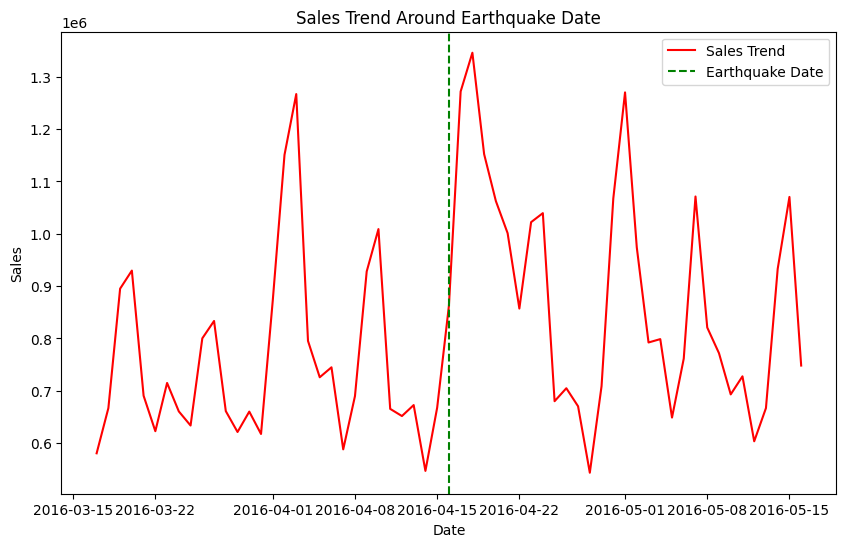

In [ ]:
earthquake_date = pd.to_datetime('2016-04-16')
start_date = earthquake_date - pd.DateOffset(days=30)
end_date = earthquake_date + pd.DateOffset(days=30)
sales_around_earthquake = oil_sales_data.loc[(oil_sales_data.index >= start_date) & (oil_sales_data.index <= end_date)]
print(sales_around_earthquake)


plt.figure(figsize=(10, 6))
plt.plot(sales_around_earthquake.index, sales_around_earthquake['sales'],  color= 'red', label='Sales Trend')
plt.axvline(x=earthquake_date, color='green', linestyle='--', label='Earthquake Date')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('Sales Trend Around Earthquake Date')
plt.legend()
plt.show()


The earthquake did not appear to have a noticeable effect on sales. The chart above illustrates a consistent upward trend in sales from April 16th, 2016, to April 22nd, 2016. Despite the occurrence of the earthquake on April 16th, 2016, sales continued to follow a consistent pattern.

4. Are certain groups of stores selling more product?

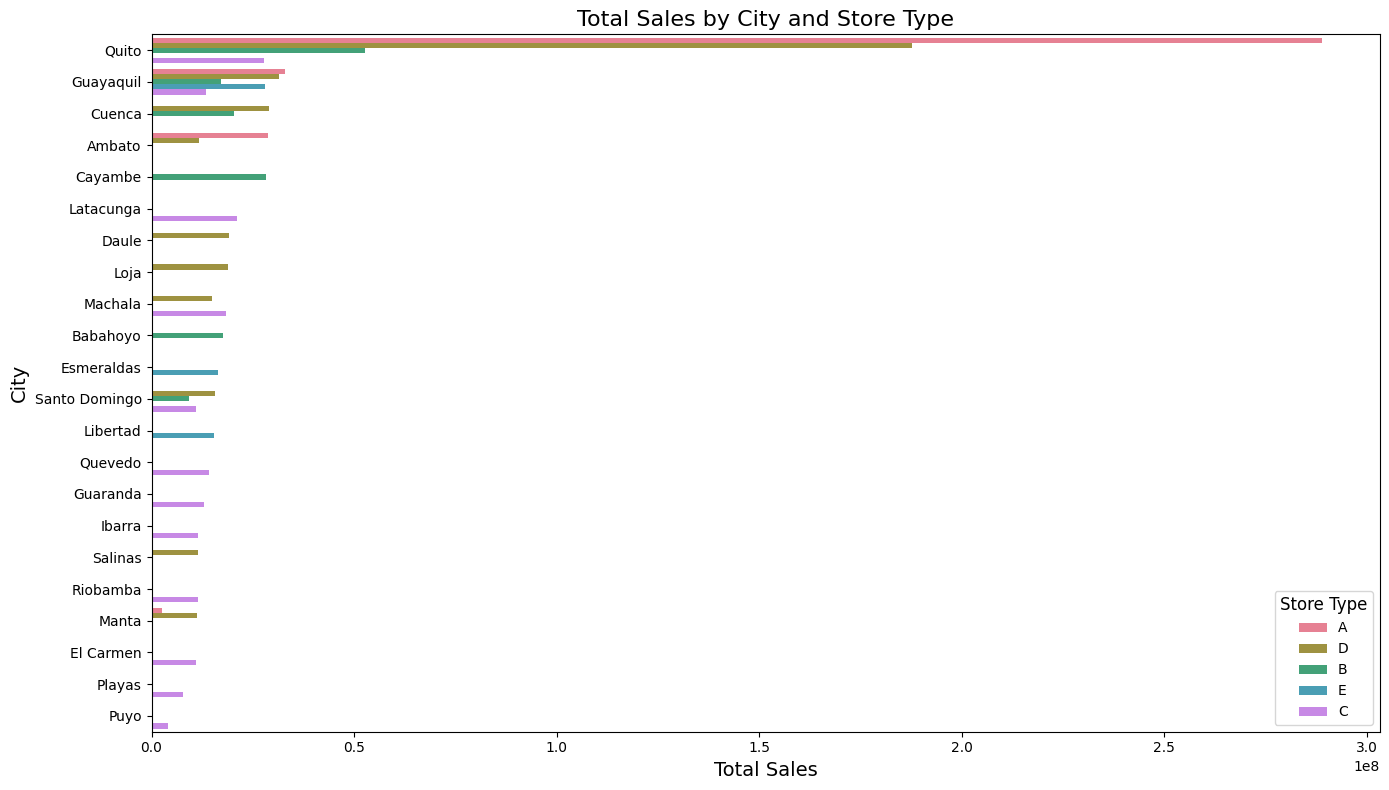

In [ ]:
merged_data = pd.merge(train_data, stores_data, on='store_nbr')
grouped_data = merged_data.groupby(["city", "state", "type"])["sales"].sum().reset_index()
grouped_data = grouped_data.sort_values(by='sales', ascending=False)

palette = sns.color_palette("husl", n_colors=len(grouped_data['type'].unique()))
plt.figure(figsize=(14, 8))
sns.barplot(x='sales', y='city', hue='type', data=grouped_data, palette=palette)
plt.title('Total Sales by City and Store Type', fontsize=16)
plt.xlabel('Total Sales', fontsize=14)
plt.ylabel('City', fontsize=14)
plt.legend(title='Store Type', title_fontsize='12', fontsize='10', loc='lower right')
plt.tight_layout()  # Adjust layout for better spacing
plt.show()

Store Type A exhibits a higher volume of product sales, particularly concentrated in the city of Quito. Additionally, Store Type D also demonstrates notable high product sales volume.

5. Relationhip between Oil prices and Sales

In [ ]:
oil_sales_data

,sales,dcoilwtico,oil_price_pct_change,sales_pct_change
date,,,,
2013-01-02,496092.417944,93.139999,0.000000,19651.897805
2013-01-03,361461.231124,92.970001,-0.182519,-27.138328
2013-01-04,354459.677093,93.120003,0.161344,-1.937014
2013-01-05,477350.121229,93.199997,0.085904,34.669795
2013-01-06,519695.401088,93.199997,0.000000,8.870906
...,...,...,...,...
2017-08-11,826373.722022,48.810001,0.556243,26.863728
2017-08-12,792630.535079,47.590000,-2.499490,-4.083284
2017-08-13,865639.677471,47.590000,0.000000,9.210993


In [ ]:
promotion_sales = train_data.groupby('date').sales.sum()
promotion_data = pd.merge(promotion_sales, oil_data[['date', 'dcoilwtico']], on='date', how='left')
promotion_data = promotion_data.set_index('date').dropna()
promotion_data.dropna(inplace=True)

promotion_data.head()


,sales,dcoilwtico
date,,
2013-01-02,496092.417944,93.139999
2013-01-03,361461.231124,92.970001
2013-01-04,354459.677093,93.120003
2013-01-07,336122.801066,93.199997
2013-01-08,318347.777981,93.209999


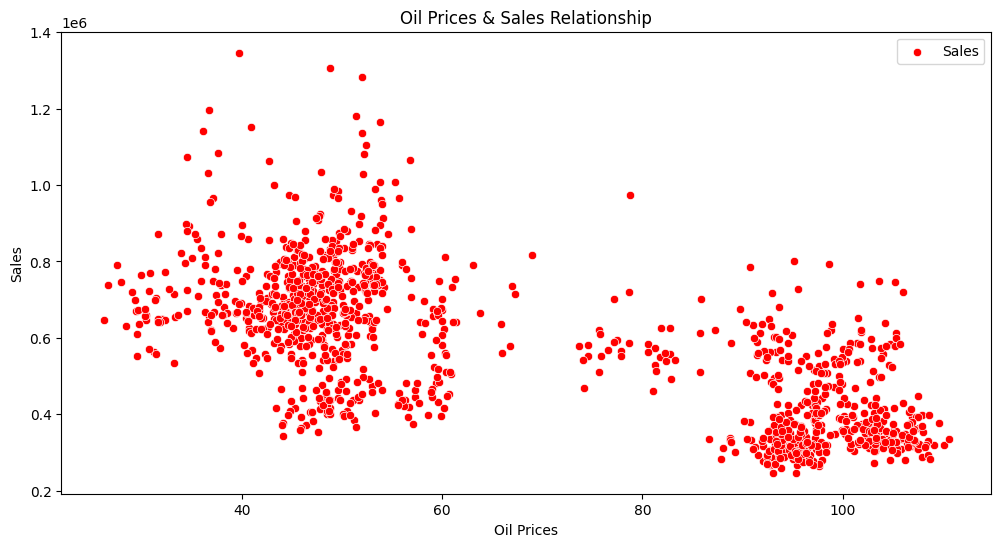

In [ ]:
plt.figure(figsize=(12, 6))
sns.scatterplot(x=promotion_data['dcoilwtico'], y=promotion_data['sales'], color='red', label='Sales')
plt.title('Oil Prices & Sales Relationship')
plt.xlabel('Oil Prices')
plt.ylabel('Sales')
plt.legend()
plt.show()


It can be observed that there is a noticeable relationship between oil prices and sales. The plot shows that there are more sales when oil prices range between 40 and 60, and there is poor sales between 60 and 80, with a fairly stable observation between 80 and 100. The density of the dots illustrates this.

6. Relationship between promotion and sales

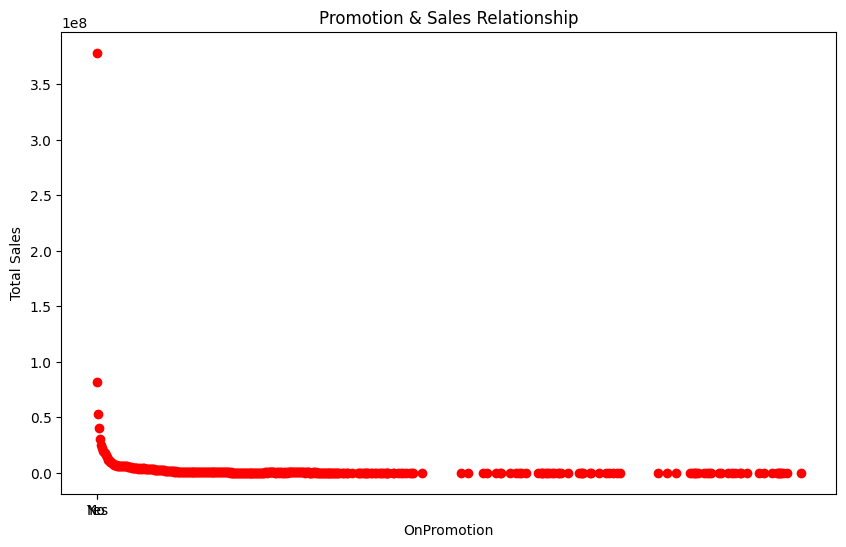

In [ ]:
promotion_sales = train_data.groupby('onpromotion')['sales'].sum().reset_index()

plt.figure(figsize=(10, 6))
plt.scatter(promotion_sales['onpromotion'], promotion_sales['sales'], color='red')
plt.title('Promotion & Sales Relationship')
plt.xlabel('OnPromotion')
plt.ylabel('Total Sales')
plt.xticks([False, True], ['No', 'Yes'])  
plt.show()

The scatter plot suggests that sales show a relatively lower sensitivity to promotions. Notably, in stores where promotions were absent (promotion value of 0), sales tend to be significantly higher compared to stores where specific products were promoted.

### Feature Engineering and Modelling

Merging the data sets

In [ ]:
merged_data = pd.merge(train_data, stores_data, on='store_nbr')
merged_data = pd.merge(merged_data, oil_data, on=['date'])
merged_data = pd.merge(merged_data, transactions_data, on=['date', 'store_nbr'])
merged_data = pd.merge(merged_data, holidays_data, on='date')
merged_data.to_csv('Csv_files\\merged_data.csv', index=False)

merged_data



,id,date,store_nbr,family,sales,onpromotion,year,Unnamed: 0_x,city,state,...,cluster,Unnamed: 0_y,dcoilwtico,transactions,Unnamed: 0,type_y,locale,locale_name,description,transferred
0,561,2013-01-01,25,AUTOMOTIVE,0.000,0,2013,24,Salinas,Santa Elena,...,1,0,NaN,770,41,Holiday,National,Ecuador,Primer dia del ano,False
1,562,2013-01-01,25,BABY CARE,0.000,0,2013,24,Salinas,Santa Elena,...,1,0,NaN,770,41,Holiday,National,Ecuador,Primer dia del ano,False
2,563,2013-01-01,25,BEAUTY,2.000,0,2013,24,Salinas,Santa Elena,...,1,0,NaN,770,41,Holiday,National,Ecuador,Primer dia del ano,False
3,564,2013-01-01,25,BEVERAGES,810.000,0,2013,24,Salinas,Santa Elena,...,1,0,NaN,770,41,Holiday,National,Ecuador,Primer dia del ano,False
4,565,2013-01-01,25,BOOKS,0.000,0,2013,24,Salinas,Santa Elena,...,1,0,NaN,770,41,Holiday,National,Ecuador,Primer dia del ano,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
322042,3000883,2017-08-15,9,POULTRY,438.133,0,2017,8,Quito,Pichincha,...,6,1205,47.57,2155,326,Holiday,Local,Riobamba,Fundacion de Riobamba,False
322043,3000884,2017-08-15,9,PREPARED FOODS,154.553,1,2017,8,Quito,Pichincha,...,6,1205,47.57,2155,326,Holiday,Local,Riobamba,Fundacion de Riobamba,False
322044,3000885,2017-08-15,9,PRODUCE,2419.729,148,2017,8,Quito,Pichincha,...,6,1205,47.57,2155,326,Holiday,Local,Riobamba,Fundacion de Riobamba,False
322045,3000886,2017-08-15,9,SCHOOL AND OFFICE SUPPLIES,121.000,8,2017,8,Quito,Pichincha,...,6,1205,47.57,2155,326,Holiday,Local,Riobamba,Fundacion de Riobamba,False


In [ ]:
merged_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 322047 entries, 0 to 322046
Data columns (total 21 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   id            322047 non-null  int64         
 1   date          322047 non-null  datetime64[ns]
 2   store_nbr     322047 non-null  int64         
 3   family        322047 non-null  object        
 4   sales         322047 non-null  float64       
 5   onpromotion   322047 non-null  int64         
 6   year          322047 non-null  int32         
 7   Unnamed: 0_x  322047 non-null  int64         
 8   city          322047 non-null  object        
 9   state         322047 non-null  object        
 10  type_x        322047 non-null  object        
 11  cluster       322047 non-null  int64         
 12  Unnamed: 0_y  322047 non-null  int64         
 13  dcoilwtico    300003 non-null  float64       
 14  transactions  322047 non-null  int64         
 15  Unnamed: 0    322

In [ ]:
merged_data = merged_data.rename(columns={'type_x': 'holiday_type', 'type_y': 'store_type'})
merged_data.drop(columns=['Unnamed: 0_y', 'Unnamed: 0_x', 'city', 'cluster', 'id','Unnamed: 0','description', 'locale', 'locale_name', 'state', 'store_type'], inplace=True)
merged_data.head()

,date,store_nbr,family,sales,onpromotion,year,holiday_type,dcoilwtico,transactions,transferred
0,2013-01-01,25,AUTOMOTIVE,0.0,0,2013,D,NaN,770,False
1,2013-01-01,25,BABY CARE,0.0,0,2013,D,NaN,770,False
2,2013-01-01,25,BEAUTY,2.0,0,2013,D,NaN,770,False
3,2013-01-01,25,BEVERAGES,810.0,0,2013,D,NaN,770,False
4,2013-01-01,25,BOOKS,0.0,0,2013,D,NaN,770,False


In [ ]:
test_data = pd.read_csv('Csv_files\\test.csv')
test_data.head()

,id,date,store_nbr,family,onpromotion
0,3000888,2017-08-16,1,AUTOMOTIVE,0
1,3000889,2017-08-16,1,BABY CARE,0
2,3000890,2017-08-16,1,BEAUTY,2
3,3000891,2017-08-16,1,BEVERAGES,20
4,3000892,2017-08-16,1,BOOKS,0


In [ ]:
merged_data["dcoilwtico"].fillna(merged_data["dcoilwtico"].mean(), inplace=True)
merged_data["transactions"].fillna(0, inplace=True)
merged_data["sales"].fillna(0, inplace=True)

merged_data.isna().sum()

date            0
store_nbr       0
family          0
sales           0
onpromotion     0
year            0
holiday_type    0
dcoilwtico      0
transactions    0
transferred     0
dtype: int64

In [ ]:
merged_data['date'] = pd.to_datetime(merged_data['date'])
merged_data['year'] = merged_data['date'].dt.year
merged_data['month'] = merged_data['date'].dt.month
merged_data['day'] = merged_data['date'].dt.day
merged_data['day_of_week'] = merged_data['date'].dt.dayofweek

In [ ]:
merged_data['date'] = merged_data['date'].apply(lambda x: pd.Timestamp(x).timestamp()).astype(float)
merged_data.head()

,date,store_nbr,family,sales,onpromotion,year,holiday_type,dcoilwtico,transactions,transferred,month,day,day_of_week
0,1.356998e+09,25,AUTOMOTIVE,0.0,0,2013,D,64.077912,770,False,1,1,1
1,1.356998e+09,25,BABY CARE,0.0,0,2013,D,64.077912,770,False,1,1,1
2,1.356998e+09,25,BEAUTY,2.0,0,2013,D,64.077912,770,False,1,1,1
3,1.356998e+09,25,BEVERAGES,810.0,0,2013,D,64.077912,770,False,1,1,1
4,1.356998e+09,25,BOOKS,0.0,0,2013,D,64.077912,770,False,1,1,1


In [ ]:
encoder = ce.BinaryEncoder(cols=['holiday_type', 'family', 'transferred'])
merged_data = encoder.fit_transform(merged_data)

merged_data.head()

,date,store_nbr,family_0,family_1,family_2,family_3,family_4,family_5,sales,onpromotion,...,holiday_type_0,holiday_type_1,holiday_type_2,dcoilwtico,transactions,transferred_0,transferred_1,month,day,day_of_week
0,1.356998e+09,25,0,0,0,0,0,1,0.0,0,...,0,0,1,64.077912,770,0,1,1,1,1
1,1.356998e+09,25,0,0,0,0,1,0,0.0,0,...,0,0,1,64.077912,770,0,1,1,1,1
2,1.356998e+09,25,0,0,0,0,1,1,2.0,0,...,0,0,1,64.077912,770,0,1,1,1,1
3,1.356998e+09,25,0,0,0,1,0,0,810.0,0,...,0,0,1,64.077912,770,0,1,1,1,1
4,1.356998e+09,25,0,0,0,1,0,1,0.0,0,...,0,0,1,64.077912,770,0,1,1,1,1


In [ ]:
merged_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 322047 entries, 0 to 322046
Data columns (total 21 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   date            322047 non-null  float64
 1   store_nbr       322047 non-null  int64  
 2   family_0        322047 non-null  int64  
 3   family_1        322047 non-null  int64  
 4   family_2        322047 non-null  int64  
 5   family_3        322047 non-null  int64  
 6   family_4        322047 non-null  int64  
 7   family_5        322047 non-null  int64  
 8   sales           322047 non-null  float64
 9   onpromotion     322047 non-null  int64  
 10  year            322047 non-null  int32  
 11  holiday_type_0  322047 non-null  int64  
 12  holiday_type_1  322047 non-null  int64  
 13  holiday_type_2  322047 non-null  int64  
 14  dcoilwtico      322047 non-null  float64
 15  transactions    322047 non-null  int64  
 16  transferred_0   322047 non-null  int64  
 17  transferre

Splitting the data set

In [ ]:

X = merged_data.drop(columns='sales')
y = merged_data['sales']


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train.set_index('date', inplace=True)
X_test.set_index('date', inplace=True)


In [ ]:
X_test.isnull().sum()

store_nbr         0
family_0          0
family_1          0
family_2          0
family_3          0
family_4          0
family_5          0
onpromotion       0
year              0
holiday_type_0    0
holiday_type_1    0
holiday_type_2    0
dcoilwtico        0
transactions      0
transferred_0     0
transferred_1     0
month             0
day               0
day_of_week       0
dtype: int64

Regression Model

In [ ]:
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [ ]:
model_predictions = model.predict(X_test)

mae = mean_absolute_error(y_test, model_predictions)
mse = mean_squared_error(y_test, model_predictions)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, model_predictions)

model_metrics = pd.DataFrame({'Model': ['Linear Regression'], 'MAE': [mae], 'MSE': [mse], 'RMSE': [rmse], 'R2': [r2]})
model_metrics

,Model,MAE,MSE,RMSE,R2
0,Linear Regression,493.216912,1.177982e+06,1085.348902,0.288867


Decision Tree Regression Model

In [ ]:
model = DecisionTreeRegressor()
model.fit(X_train, y_train)

DecisionTreeRegressor()

In [ ]:
model_predictions = model.predict(X_test)

mae = mean_absolute_error(y_test, model_predictions)
mse = mean_squared_error(y_test, model_predictions)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, model_predictions)

model_metrics = pd.concat([model_metrics, pd.DataFrame({'Model': ['Decision Tree'], 'MAE': [mae], 'MSE': [mse], 'RMSE': [rmse], 'R2': [r2]})])
model_metrics

,Model,MAE,MSE,RMSE,R2
0,Linear Regression,493.216912,1.177982e+06,1085.348902,0.288867
0,Decision Tree,86.353252,3.043474e+05,551.676892,0.816269


Random Forest

In [ ]:
model = RandomForestRegressor()
model.fit(X_train, y_train)

RandomForestRegressor()

In [ ]:
model_predictions = model.predict(X_test)

mae = mean_absolute_error(y_test, model_predictions)
mse = mean_squared_error(y_test, model_predictions)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, model_predictions)

model_metrics = pd.concat([model_metrics, pd.DataFrame({'Model': ['Random Forest'], 'MAE': [mae], 'MSE': [mse], 'RMSE': [rmse], 'R2': [r2]})])
model_metrics

,Model,MAE,MSE,RMSE,R2
0,Linear Regression,493.216912,1.177982e+06,1085.348902,0.288867
0,Decision Tree,86.353252,3.043474e+05,551.676892,0.816269
0,Random Forest,68.316712,1.859761e+05,431.249502,0.887729


XGBoost

In [ ]:
model = XGBRegressor()
model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [ ]:
model_predictions = model.predict(X_test)

mae = mean_absolute_error(y_test, model_predictions)
mse = mean_squared_error(y_test, model_predictions)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, model_predictions)

model_metrics = pd.concat([model_metrics, pd.DataFrame({'Model': ['XGBoost'], 'MAE': [mae], 'MSE': [mse], 'RMSE': [rmse], 'R2': [r2]})])
model_metrics

,Model,MAE,MSE,RMSE,R2
0,Linear Regression,493.216912,1.177982e+06,1085.348902,0.288867
0,Decision Tree,86.353252,3.043474e+05,551.676892,0.816269
0,Random Forest,68.316712,1.859761e+05,431.249502,0.887729
0,XGBoost,164.181477,2.791462e+05,528.342900,0.831483


The table below shows the performance metrics (MAE, MSE, RMSE, R2) for the 4 different models: 

| Model            | MAE       | MSE       | RMSE      | R2        |
|------------------|-----------|-----------|-----------|-----------|
| Linear Regression| 493.216912| 1.177982e+06| 1085.348902| 0.288867  |
| Decision Tree    | 86.353252 | 3.043474e+05| 551.676892| 0.816269  |
| Random Forest    | 68.316712 | 1.859761e+05| 431.249502| 0.887729  |
| XGBoost          | 164.181477| 2.791462e+05| 528.342900| 0.831483  |

Here are my comments:


- **Linear Regression**: It has the highest MAE, MSE, and RMSE among the models, indicating that it performs the worst in terms of error metrics. The R2 score is also the lowest, suggesting that it explains the least amount of variance in the data.

- **Decision Tree**: It performs better than Linear Regression, with significantly lower error metrics (MAE, MSE, RMSE). The R2 score is higher, indicating that it explains more variance in the data compared to Linear Regression.

- **Random Forest**: This model shows further improvement over the Decision Tree, with even lower error metrics and a higher R2 score. It performs the best among the models listed here.

- **XGBoost**: While XGBoost has lower error metrics compared to Linear Regression, it performs slightly worse than Random Forest in terms of MAE, MSE, and RMSE. However, its R2 score is still higher than Linear Regression and Decision Tree, indicating it explains more variance than these models.

Random Forest seems to be the best-performing model based on these metrics, followed by XGBoost, Decision Tree, and then Linear Regression.